In [1]:
import numpy as np
import time

# Ring-LWE parameters (small for education)
n = 256              # Polynomial degree (power of 2)
q = 3329             # Prime modulus (Kyber-like)

def poly_add(a, b):
    return (a + b) % q

def poly_mul_naive(a, b):
    result = np.zeros(n, dtype=int)
    for i in range(n):
        for j in range(n):
            idx = (i + j) % n
            sign = -1 if (i + j) >= n else 1  # x^n = -1
            result[idx] += sign * a[i] * b[j]
    return result % q

#NTT
root = 17  # Primitive root modulo q

def bit_reverse(a):
    n = len(a)
    result = np.zeros(n, dtype=int)
    logn = int(np.log2(n))
    for i in range(n):
        j = int('{:0{width}b}'.format(i, width=logn)[::-1], 2)
        result[j] = a[i]
    return result

def ntt(a):
    a = bit_reverse(a.copy())
    length = 2
    while length <= n:
        wlen = pow(root, (q - 1) // length, q)
        for i in range(0, n, length):
            w = 1
            for j in range(i, i + length // 2):
                u = a[j]
                v = (a[j + length // 2] * w) % q
                a[j] = (u + v) % q
                a[j + length // 2] = (u - v) % q
                w = (w * wlen) % q
        length *= 2
    return a

def intt(a):
    inv_n = pow(n, q - 2, q)
    a = ntt(a)
    return (a * inv_n) % q

def poly_mul_ntt(a, b):
    A = ntt(a)
    B = ntt(b)
    C = (A * B) % q
    return intt(C)

def keygen():
    s = np.random.randint(0, 2, size=n)      # secret key
    a = np.random.randint(0, q, size=n)      # public polynomial
    e = np.random.randint(-1, 2, size=n)     # error
    b = (poly_mul_naive(a, s) + e) % q
    return (a, b), s

def encrypt(m, public_key, use_ntt=False):
    a, b = public_key
    r = np.random.randint(0, 2, size=n)
    e1 = np.random.randint(-1, 2, size=n)
    e2 = np.random.randint(-1, 2, size=n)

    mul = poly_mul_ntt if use_ntt else poly_mul_naive

    c1 = (mul(a, r) + e1) % q
    c2 = (mul(b, r) + e2 + m) % q
    return c1, c2

def benchmark(iterations=10):
    public_key, secret_key = keygen()
    message = np.random.randint(0, 2, size=n)

    # Naïve Ring-LWE
    start = time.time()
    for _ in range(iterations):
        encrypt(message, public_key, use_ntt=False)
    naive_time = time.time() - start

    # NTT Ring-LWE
    start = time.time()
    for _ in range(iterations):
        encrypt(message, public_key, use_ntt=True)
    ntt_time = time.time() - start

    print(f"Naïve Ring-LWE time: {naive_time:.4f} s")
    print(f"NTT Ring-LWE time:   {ntt_time:.4f} s")
    print(f"Speedup: {naive_time / ntt_time:.2f}×")


In [6]:
benchmark(iterations=5)


Naïve Ring-LWE time: 0.2774 s
NTT Ring-LWE time:   0.0338 s
Speedup: 8.21×


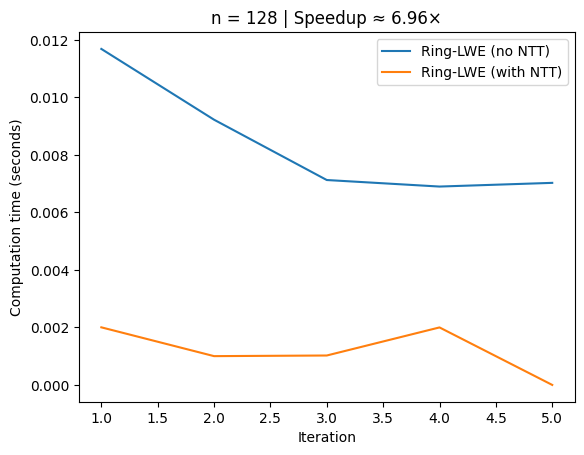

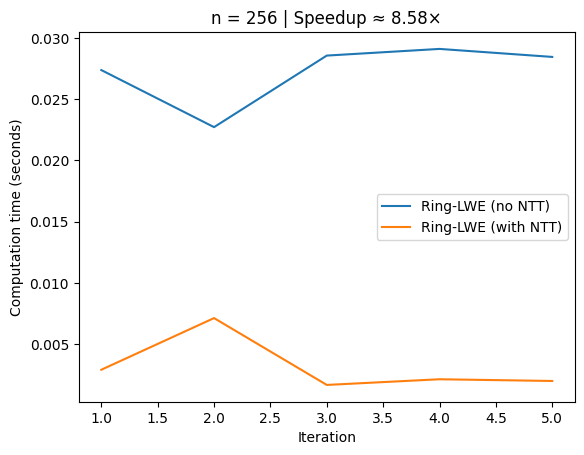

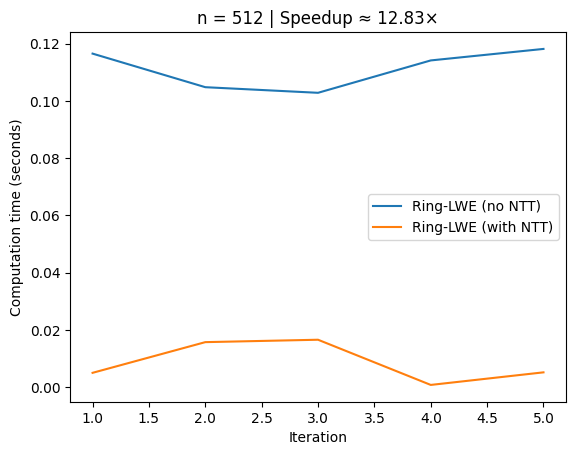

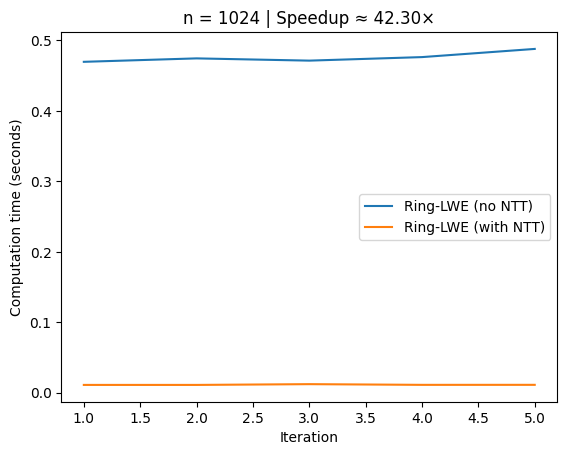

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt

# =========================
# Global PQC Parameters
# =========================

q = 3329          # Prime modulus (Kyber-like)
root = 17         # Primitive root modulo q


# =========================
# Naïve Polynomial Multiplication
# O(n^2)
# =========================

def poly_mul_naive(a, b, n):
    result = np.zeros(n, dtype=int)
    for i in range(n):
        for j in range(n):
            idx = (i + j) % n
            sign = -1 if (i + j) >= n else 1  # x^n = -1
            result[idx] += sign * a[i] * b[j]
    return result % q


# =========================
# NTT Utilities
# =========================

def bit_reverse(a):
    n = len(a)
    result = np.zeros(n, dtype=int)
    logn = int(np.log2(n))
    for i in range(n):
        j = int(f"{i:0{logn}b}"[::-1], 2)
        result[j] = a[i]
    return result


def ntt(a, n):
    a = bit_reverse(a.copy())
    length = 2
    while length <= n:
        wlen = pow(root, (q - 1) // length, q)
        for i in range(0, n, length):
            w = 1
            for j in range(i, i + length // 2):
                u = a[j]
                v = (a[j + length // 2] * w) % q
                a[j] = (u + v) % q
                a[j + length // 2] = (u - v) % q
                w = (w * wlen) % q
        length *= 2
    return a


def intt(a, n):
    inv_n = pow(n, q - 2, q)
    return (ntt(a, n) * inv_n) % q


def poly_mul_ntt(a, b, n):
    A = ntt(a, n)
    B = ntt(b, n)
    C = (A * B) % q
    return intt(C, n)


# =========================
# Benchmark Function
# =========================

def benchmark(n, iterations=5):
    a = np.random.randint(0, q, size=n)
    b = np.random.randint(0, q, size=n)

    naive_times = []
    ntt_times = []

    for _ in range(iterations):
        start = time.time()
        poly_mul_naive(a, b, n)
        naive_times.append(time.time() - start)

        start = time.time()
        poly_mul_ntt(a, b, n)
        ntt_times.append(time.time() - start)

    speedup = sum(naive_times) / sum(ntt_times)
    return naive_times, ntt_times, speedup


# =========================
# Run Benchmarks + Plot
# =========================

ns = [128, 256, 512, 1024]

for n in ns:
    naive, ntt_times, speedup = benchmark(n)
    iterations = list(range(1, len(naive) + 1))

    plt.figure()
    plt.plot(iterations, naive, label="Ring-LWE (no NTT)")
    plt.plot(iterations, ntt_times, label="Ring-LWE (with NTT)")
    plt.xlabel("Iteration")
    plt.ylabel("Computation time (seconds)")
    plt.title(f"n = {n} | Speedup ≈ {speedup:.2f}×")
    plt.legend()
    plt.show()
